# EE4414 Lab Time_Series_Prediction

## Acknowledgment

This lab experiment is inspired by Usman Malik's Stack Abuse article.

You can check out the original post at https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python



## 1. Training a time series predictor

A time series data is a sequential data indexed in time order.
Often we would like to predict the future behaviour of a time series.
For example, we may be interested in predicting the weather, share prices, sales, etc. 
Long Short-Term Memory (LSTM) model can be applied to perform time series prediction. 

In this exercise, we will use the ``flights`` dataset from the seaborn library.
The dataset contains 3 columns: ``year``, ``month``, and ``passengers``.
Where the ``year`` and ``month`` columns refer to the particular year and month of the monthly flight record, respectively.
The ``passengers`` column records the total number of passengers that took the flights in that month.

We will do the following steps in order:

1) Load and normalize the training and testing datasets using ``StandardScalar``
   
2) Define an LSTM model

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1.1 Loading the flights dataset


Loading the ``flights`` data from ``seaborn`` is strightforward.

In [3]:
import seaborn as sns

flights = sns.load_dataset('flights')
print(type(flights)) # the dataset is loaded as pandas dataframe
flights.describe(include = 'all')

# save the data as comma-separated values (csv) to facilitate viewing of the raw data
flights.to_csv('flights_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>



### 1.2 Visualizing the training data


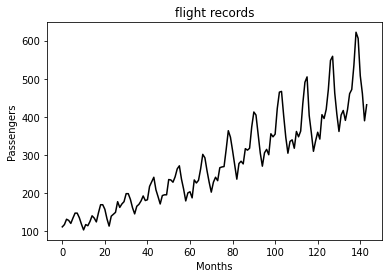

In [4]:
plt.plot(flights['passengers'], 'k')
plt.title('flight records')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.show()

### 1.3 Normalizing the data and converting to tensor

In a regression problem such as this, it is beneficial to normalize the data. It allows the model to converge faster and avoid having large losses. 

In [5]:
from sklearn.preprocessing import StandardScaler

passengers = flights['passengers'].values.astype(float) # convert the passengers column to float 
scaler = StandardScaler()
normalized_data = scaler.fit_transform(passengers.reshape(-1,1))

### 1.4 Generating the sequences
Since we have 144 months (i.e., 12 years) of flight data, we use 132 months (i.e., 11 years) for training and the remaining 12 months (i.e., 1 year) for testing.

In [6]:
# create windowed sequence tuples of (x,y), with moving window of step size = 1
#window_size is the number of data points in each sequence, and test_size is the number of data points you want to hold out for testing.
def windowed_sequences(data, window_size=12, test_size=12):
    x = []
    y = []
    for i in range(len(data)-window_size-test_size+1):
        j = i + window_size
        xi = data[i:j]
        yi = data[j]
        #xi represents "past" values, and yi represents "future" values that you want to predict.
        x.append(xi)
        y.append(yi)
    return x, y
        
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, 12, test_size)

 # Convert the sequences to float type tensors
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float) 
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


### 1.5 Constructing the iterables

In [7]:
# Using pytorch data loading utility to construct iterable over the dataset

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item],  self.y[item]

    def __len__(self):
        return len(self.x)
    
train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)

### 1.6 Defining the LSTM model

Since we only have 1 input and 1 output value which is the number of passengers, we set the input dimension (input_dim) and output dimension (output_dim) as 1.
hidden_dim defines the number of features in the hidden state of the LSTM.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=1):
        super(TimeSeriesPredictor,self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, self.hidden_dim,
                            batch_first=True)
                
        self.fc1 = nn.Linear(self.hidden_dim, 100)
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, input_seq):

        lstm_out, (hn, cn) = self.lstm(input_seq)
        predictions = F.relu(self.fc1(hn.view(-1, self.hidden_dim)))
        predictions = self.fc2(predictions)
        return predictions
    
model = TimeSeriesPredictor()

### 1.7 Printing the network structure

In [9]:
print(model)

TimeSeriesPredictor(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### 1.8 Using Torchinfo to view a summary of the network parameters

In [10]:
from torchinfo import summary
summary(model, input_size=(24,12,1)) # (batch_size, sequence_length, input_dim)

Layer (type:depth-idx)                   Output Shape              Param #
TimeSeriesPredictor                      [24, 1]                   --
├─LSTM: 1-1                              [24, 12, 200]             162,400
├─Linear: 1-2                            [24, 100]                 20,100
├─Linear: 1-3                            [24, 1]                   101
Total params: 182,601
Trainable params: 182,601
Non-trainable params: 0
Total mult-adds (M): 47.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.73
Estimated Total Size (MB): 1.21

### 1.9 Defining loss function and optimizer

The loss function is defined as Mean Squared Error loss and optimizer is Adam optimizer. 



In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### 1.10 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [12]:
model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.1091
epoch: 200 loss: 0.0402
epoch: 300 loss: 0.0253
epoch: 400 loss: 0.0179
epoch: 500 loss: 0.0155
epoch: 600 loss: 0.0179
epoch: 700 loss: 0.0150
epoch: 800 loss: 0.0131
epoch: 900 loss: 0.0115
epoch: 1000 loss: 0.0112
Finished Training
Training time:50.85467529296875


## Exercise 1.1 Plotting of loss function

In the previous cell, we have saved the loss function at different iterations in the loss_list.

Now, plot the loss function versus the iteration number using matplotlib.

You can find the tutorial of plotting figures using matplotlib here:
https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/simple_plot.html#sphx-glr-gallery-lines-bars-and-markers-simple-plot-py

### E1.1.1 Example of using matplotlib.pyplot

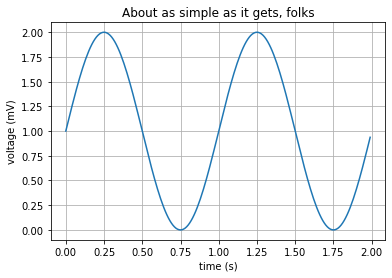

In [13]:
# An example of a simple plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()

### E1.1.2 Plotting the loss function vs interation number (To do)

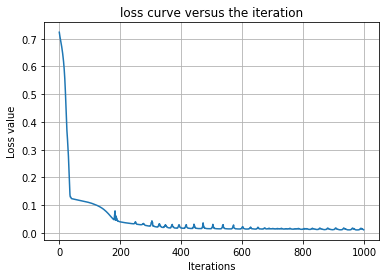

In [14]:
# Plot the training loss curve
# To do
iterations = np.arange(len(loss_list))

fig, ax = plt.subplots()
ax.plot(iterations, loss_list)
ax.set(xlabel='Iterations', ylabel='Loss value',
       title='loss curve versus the iteration')
ax.grid()

plt.show()

### 1.11 Evaluating network performance on the test data

We have trained the network for several passes over the training dataset.
But we need to check if the network has learned anything at all.

We will check this by predicting the next time-step value that the neural network
outputs, and checking it against the ground truth.



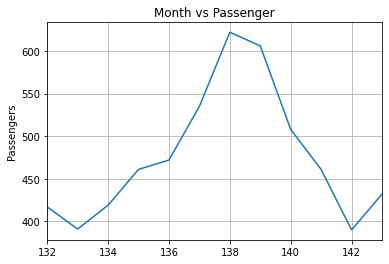

In [15]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis, passengers[-test_size:])
plt.show()

### 1.12 Perform predictions using the trained model



In [16]:
preds_sl12 = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_sl12.append(outputs)

## Exercise 1.2 Evaluating network performance 

In this section, we are going to evaluate the accuracy of the model in predicting future values. Since we are predicting more than 1 value, we will use the Mean Absolute Percentage Error (MAPE) to measure the difference between the predicted value and the ground truth value. 

### E1.2.1 Computing MAPE (To do)

Finish the code and calculate the MAPE for 12 future predictions. They can be computed using API from scikit-learn:

MAPE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

denormalized_preds_sl12 = scaler.inverse_transform(np.array(preds_sl12).reshape(-1, 1))
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_sl12)
print('MAPE: %.2f%%' % (mape*100))

MAPE: 11.85%


c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package 

### E1.2.2 Plotting the predictions against the data

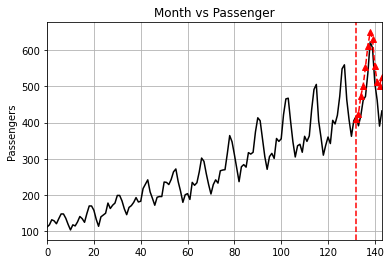

In [18]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(passengers, 'k')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.axvline(x=132, color='r', linestyle='--')
plt.show()

### E1.2.3 Zoom in to the predictions

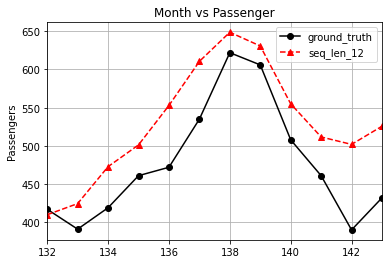

In [19]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.legend()
plt.show()

## E1.3 Study of different window/sequence lengths

In this exercise, you will learn to train the network with the input of a different window/sequence length.

In the previous section, we used a sequence length of 12 for the time series input. You will use a sequence length of 24 in this exercise and compare the evaluation results for these two window/sequence lengths.

### E1.3.1 Prepare the new training iterables (To do)

In [20]:
window_size = 24
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, window_size, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=12) # Reduce batch_size to prevent out of memory
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### E1.3.2 Re-initializing the network and optimizer

In [21]:
model = TimeSeriesPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
print(model)

TimeSeriesPredictor(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### E1.3.3 Training the network with the new input sequences

In [24]:
model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.1174
epoch: 200 loss: 0.0480
epoch: 300 loss: 0.0372
epoch: 400 loss: 0.0287
epoch: 500 loss: 0.0218
epoch: 600 loss: 0.0189
epoch: 700 loss: 0.0154
epoch: 800 loss: 0.0142
epoch: 900 loss: 0.0128
epoch: 1000 loss: 0.0113
Finished Training
Training time:106.14038801193237


### E1.3.4 Perform predictions

Perform predictions using the model trained on inputs sequence length = 24.

In [25]:
preds_sl24 = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-24:]
        preds_sl24.append(outputs)

### E1.3.5 Evaluate performance

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

denormalized_preds_sl24 = scaler.inverse_transform(np.array(preds_sl24).reshape(-1, 1))
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_sl24)
print('MAPE: %.2f%%' % (mape*100))

MAPE: 6.39%


c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package 

### E1.3.6 Plotting the results for both sequence lengths (To do)


Re-plot the plot in E1.2.3 by adding the input-sequence-length-24 prediction. 

Specifically, plot the ground truth (in black and label it as 'ground truth'), the sequence-length-12 prediction (in red dotted line with ^ marker and label it as 'seq_len_12'), and the sequence-length-24 prediction (in green dotted line with x marker and label it as 'seq_len_24').

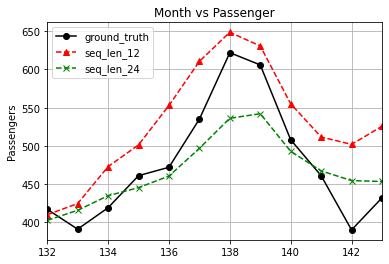

In [27]:
# To do
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis, passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis, denormalized_preds_sl12, 'r^--', label='seq_len_12')
plt.plot(x_axis, denormalized_preds_sl24, 'gx--', label='seq_len_24')
plt.legend()
plt.show()

## Exercise 1.4 Study of different hidden dimensions

In this exercise, you will learn to train the network using a different hidden layer dimension.

In the previous section, we used a hidden dimension of 200. You will use a hidden dimension of 400 in this exercise and compare the results for these 2 hidden dimensions. We will keep the window/sequence length of 12.

### E1.4.1 Re-initializing the network with different hidden dimensions (To do)

In [ ]:
# To do
model = TimeSeriesPredictor(hidden_dim=400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # lower learning may be better for more complex model

### E1.4.2 View a summary of the network parameters

In [ ]:
from torchinfo import summary
summary(model, input_size=(24,12,1))

Layer (type:depth-idx)                   Output Shape              Param #
TimeSeriesPredictor                      [24, 1]                   --
├─LSTM: 1-1                              [24, 12, 400]             644,800
├─Linear: 1-2                            [24, 100]                 40,100
├─Linear: 1-3                            [24, 1]                   101
Total params: 685,001
Trainable params: 685,001
Non-trainable params: 0
Total mult-adds (M): 186.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.94
Params size (MB): 2.74
Estimated Total Size (MB): 3.68

### E1.4.3 Reinitialize the training iterables

In [ ]:
window_size = 12
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, window_size, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### E1.4.4 Training the network with new hidden dimension

In [ ]:
model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.0740
epoch: 200 loss: 0.0302
epoch: 300 loss: 0.0243
epoch: 400 loss: 0.0205
epoch: 500 loss: 0.0178
epoch: 600 loss: 0.0183
epoch: 700 loss: 0.0375
epoch: 800 loss: 0.0133
epoch: 900 loss: 0.0137
epoch: 1000 loss: 0.0131
Finished Training
Training time:191.17661261558533


### E1.4.5 Perform predictions

In [ ]:
preds_hd400 = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_hd400.append(outputs)

### E1.4.6 Evaluate performance

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

denormalized_preds_hd400 = scaler.inverse_transform(np.array(preds_hd400).reshape(-1, 1))
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_hd400)
print('MAPE: %.2f%%' % (mape*100))

MAPE: 6.65%


c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package 

### E1.4.7 Plotting the results in the same plot (To do)

Re-plot the plot in E1.2.3 by adding the hidden-dimension-400 prediction. 

Specifically, plot the the ground truth (in black and label it as 'ground truth'), the hidden-dimension-200 prediction (in red dotted line with ^ marker and label it as 'hid_dim_200'), and the hidden-dimension-400 prediction (in green dotted line with x marker and label it as 'hid_dim_400').

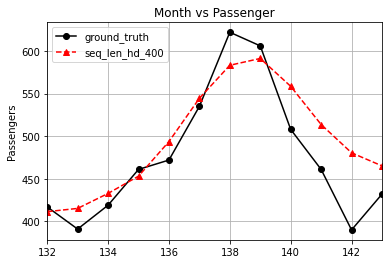

In [ ]:
# To do 
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_hd400, 'r^--', label='seq_len_hd_400')
plt.legend()
plt.show()